GPU availability: True; automation will be using: cuda:0 Mounted at /content/gdrive/
19176
21054
8726
357
17458
7941
9987
8863
12535
7705
12198
15715
9257
1435
13968
13055
20831
1692
3374
8338
16516
11485
20989
18317
3881
9249
22090
9383
11416
1483
13541
14619
(32, 3, 256, 256)
(32, 18, 32, 32)
(32, 1, 256, 256)


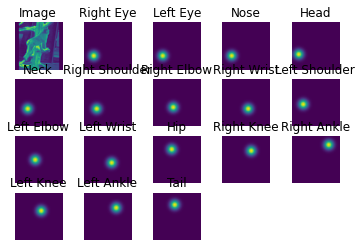

In [4]:
from matplotlib.transforms import ScaledTranslation
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 
import os
import json
from tqdm import tqdm
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math
import cv2
import skimage.filters as filters
import skimage.transform as transform
import sys
np.set_printoptions(threshold=sys.maxsize)

#Set device to GPU if possible
cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'

#print(cuda)
print("GPU availability: {}; automation will be using: {} ".format(cuda, device), end= '')

#Path to where data is stored
drive.mount('/content/gdrive/', force_remount = True)
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/Data/"

#Set automation to Train or Test
Train = False

def Load_Data():

  if(Train == True):
    dir = os.path.join(dir_path, "train_annotation.json")
  else:
    dir = os.path.join(dir_path, "val_annotation.json")

  with open(dir) as f:
      dictionary = json.load(f)
      feature_list = [item for item in dictionary['data']]
      feature_list = np.asarray(feature_list)

  return(feature_list)

def get_image(feature_list, index):

  if(Train == True):
    dir_image_folder = os.path.join(dir_path, "train")
  else:
    dir_image_folder = os.path.join(dir_path, "val")
    
  # print("dir_image_folder: ",dir_image_folder)

  feature = feature_list[index]

  dir_image = os.path.join(dir_image_folder, feature["file"])

  img = mpimg.imread(dir_image)

  #plt.imshow(img)

  return img

#Return batches with image filepaths. Will need to "get_image" by batch as
#RAM capacity is surpassed if we attempt to get all images within the create batch
#method.

def create_batches(data, batch_size):

  data_count = len(data)
  index_array = random.sample(range(0, data_count), data_count)

  mini_batch_count = math.floor(data_count/batch_size)

  mini_batch_x = []

  for batch in range(int(mini_batch_count)):
    batch_x = []
    try:
      for value in range(batch_size):
        batch_x.append(index_array[value + batch * batch_size])
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
    except:
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
  mini_batch_x = np.asarray(mini_batch_x)
  return mini_batch_x
#torch_data.dataloader(data_class, batch_size = 1, shuffle = True)

def get_batch_data(data, batch, size):
  batch_data_train_images = []
  batch_data_heat_maps = []
  batch_data_center_heat_map = []

  heat_map_size = (32, 32)
  center_map_size = (256, 256)

  for value in range(len(batch)):
    print(batch[value])
    img = get_image(data, batch[value])
    cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
    #Create ground truth heatmap and center heat map
    heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
    train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
    batch_data_train_images.append(train_image)
    batch_data_heat_maps.append(heat_maps)
    batch_data_center_heat_map.append(center_heat_map)

  batch_data_train_images = np.asarray(batch_data_train_images)
  batch_data_heat_maps = np.asarray(batch_data_heat_maps)
  batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

  return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

def crop_image(img, features, image_size):
  joint_points = features["landmarks"]
  bbox = features["bbox"]
  visibility = np.asarray(features["visibility"])

  x = []
  y = []

  for value in range(0, len(joint_points), 2):
    x.append(joint_points[value])
  width_points = np.transpose(np.asarray(x))

  for value in range(1, len(joint_points), 2):
    y.append(joint_points[value])
  height_points = np.transpose(np.asarray(y))

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 - math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 - math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Sift our Width and Height points for any zero values
  width_points = np.where(width_points != 0, width_points - bbox_x1, width_points)
  height_points = np.where(height_points != 0, height_points - bbox_y1, height_points)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]
  width_points = (width_points * image_size)/Width
  height_points = (height_points * image_size)/Width

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  joint_points = [[width_points[i], height_points[i]] for i in range(len(height_points))]

  return img, np.asarray(joint_points), np.asarray(center)

def get_heatmap(img, joint_points, cropped_center):
  heat_map_size = img[0]
  #print(heat_map_size.shape)
  Height, Width = heat_map_size.shape[0], heat_map_size.shape[1]
  #print(joint_points.shape)

  #Build shell for heatmap of each joint_point
  heat_maps = np.zeros((Height, Width, (len(joint_points) + 1)))

  for joint in range(len(joint_points)):
    if((joint_points[joint, 0] == 0) and (joint_points[joint, 1] == 0)):
      continue

    if(joint_points[joint, 1] >= Height):
      joint_points[joint, 1] = Height - 1
    if(joint_points[joint, 0] >= Width):
      joint_points[joint, 0] = Width - 1
    
    #Build heatmap of joint
    heat_map = heat_maps[:, :, joint]
    x = math.floor(joint_points[joint, 1])
    y = math.floor(joint_points[joint, 0])

    #Set heatmap of joint within heatmap image
    heat_map[x][y] = 1
    heat_map = filters.gaussian(heat_map, sigma = 2)

    #scale image to [0, 1]
    scale = np.max(heat_map)
    heat_map = heat_map/scale
    heat_maps[:, :, joint] = heat_map

  #add background dimensions
  heat_maps[:, :, len(joint_points)] = 1 - np.max(heat_maps[:, :, :len(joint_points)], axis = 2)
  heat_maps = np.transpose(heat_maps, (2, 0, 1))


  #Center image
  center_heat_map = img[1] #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return heat_maps, center_heat_map

def view_heat_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 12})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value - 1])
  plt.show()


if __name__ == '__main__':
  #Config
  crop_size = 256
  batch_size = 32

  #Load in the data for training and/or validation
  data = Load_Data()

  #Create batches containing unique indexes expanding the length of our training set
  batches_x = create_batches(data, batch_size)

  #Grab the images from each batch containing unique indexes of training data
  train_images_batch, heat_images_batch, center_image_batch = get_batch_data(data, batches_x[0], crop_size)

  print(train_images_batch.shape) # (batch size, channels, height, width)
  print(heat_images_batch.shape)
  print(center_image_batch.shape)
  #print(center_image_batch[0][0])


  view_heat_maps(train_images_batch[0][0], heat_images_batch[0])


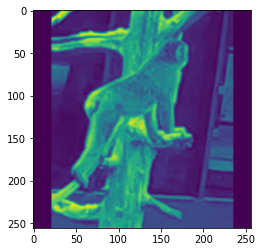

In [5]:
plt.imshow(train_images_batch[0, 0])

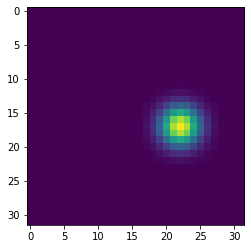

In [133]:
img = get_image(data, 1500)
cropped_image, cropped_joints, cropped_center = crop_image(img, data[1500], 256)
#Create ground truth heatmap and center heat map
heat_maps, center_heat_map = get_heatmap([np.zeros((32, 32)), np.zeros((256, 256))], cropped_joints/8, cropped_center)
train_image = np.transpose(cropped_image, (2, 0, 1))/255.0

plt.imshow(img)
#view_heat_maps(train_image[0], heat_map
#print(heat_maps.shape)
plt.imshow(heat_maps[4])
#plt.imshow(train_image[0])



In [17]:
img = get_image(data, 0)
cropped_image, cropped_joints, cropped_center = crop_image(img, 0], 256)

SyntaxError: ignored

(32, 3, 256, 256)


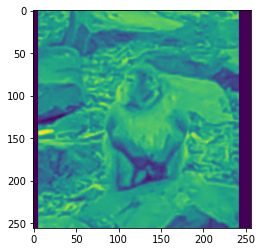

In [4]:
print(train_images_batch.shape)
plt.imshow(train_images_batch[4][0])
#plt.imshow(heat_images_batch[0][0])

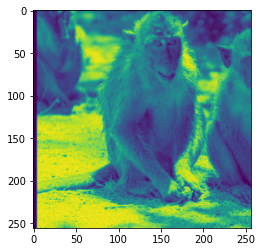

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
plt.imshow(train_images_batch[4, 0])

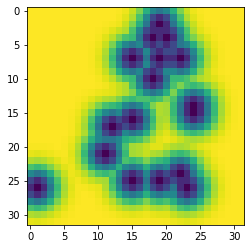

In [ ]:
plt.imshow(heat_images_batch[4, 17])

# CPM

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 

class CPM(nn.Module): # CPM model inherits nn.Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self, num_joints):
    super(CPM, self).__init__()
    self.num_joints = num_joints

    self.cpool = nn.AvgPool2d(8)                               # avg pool operation with kernel size 8 for center_image

    # To extract features (x) for every stage
    self.x_conv1 = nn.Conv2d(3, 128, 9, padding=4)             # (input channels, output channels, kernel size, padding) // output channels = number of kernels used on image, might be good to play around with values
    self.x_pool1 = nn.MaxPool2d(2)                             # max pool operation with kernel size 2
    self.x_conv2 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool2 = nn.MaxPool2d(2)                 
    self.x_conv3 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool3 = nn.MaxPool2d(2)
    self.x_conv4 = nn.Conv2d(128, 32, 5, padding=2)  

    # Stage 1 convolutions:
    self.s1_conv1 = nn.Conv2d(32, 512, 9, padding=4)
    self.s1_conv2 = nn.Conv2d(512, 512, 1)
    self.s1_conv3 = nn.Conv2d(512, num_joints+1, 1)

    # Stage >= 2 (t) convolutions:
    self.st_conv1 = nn.Conv2d(34 + num_joints, 128, 11, padding=5)  # input channels = output channels from image features (x) + output channels from previous stage + 1 channel for loss
    self.st_conv2 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv3 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv4 = nn.Conv2d(128, 128, 1)
    self.st_conv5 = nn.Conv2d(128, num_joints + 1, 1)

  def extract_features(self, im):                                   # input im shape = (N, 3, H, W) // output shape = (N, 32, H/8, W/8)    N = batch size
    x = self.x_pool1(F.relu(self.x_conv1(im)))
    x = self.x_pool2(F.relu(self.x_conv2(x)))
    x = self.x_pool3(F.relu(self.x_conv3(x)))
    return F.relu(self.x_conv4(x))
  
  def stage_1(self, x):                                             # input x shape = (N, 32, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.s1_conv1(x))
    x = F.relu(self.s1_conv2(x))
    return F.relu(self.s1_conv3(x))

  def stage_t(self, x):                                             # input x shape = (N, 34 + num_joints, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.st_conv1(x))
    x = F.relu(self.st_conv2(x))
    x = F.relu(self.st_conv3(x))
    x = F.relu(self.st_conv4(x))
    return F.relu(self.st_conv5(x))
  
  def forward(self, im, center_image): # for 6 stages
    cpool = self.cpool(center_image)

    s1_maps = self.stage_1(self.extract_features(im))
    x = self.extract_features(im)
    s2_maps = self.stage_t(torch.cat([x, s1_maps, cpool], dim=1))
    s3_maps = self.stage_t(torch.cat([x, s2_maps, cpool], dim=1))
    s4_maps = self.stage_t(torch.cat([x, s3_maps, cpool], dim=1))
    s5_maps = self.stage_t(torch.cat([x, s4_maps, cpool], dim=1))
    s6_maps = self.stage_t(torch.cat([x, s5_maps, cpool], dim=1))

    return torch.stack([s1_maps, s2_maps, s3_maps, s4_maps, s5_maps, s6_maps], dim=1)

In [3]:
from torch.utils.data import Dataset

class TrainData(Dataset):
    def __init__(self):
        super(TrainData, self).__init__()
        dir = os.path.join(dir_path, 'train_annotation.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'train', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        hm_size = (32, 32)
        cm_size = (256, 256)

        c_im, c_jts, c_cen = crop_image(im, f_d, crop_size)
        hmaps, cmap = get_heatmap([np.zeros(hm_size), np.zeros(cm_size)], c_jts/8, c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, hmaps, cmap

    def __len__(self):
        return len(self.features)

In [ ]:
lines = [0.23, 0.42]

lines = lines.tostring()
with open('/content/gdrive/MyDrive/Colab Notebooks/Data/loss.txt', 'w') as f:
    f.write('\n'.join(lines))

AttributeError: ignored

In [4]:
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'
dir = os.path.join(dir_path, "cpm_baseline.pth")

epochs = 500
lr = 0.0001
model = CPM(17).to(device)
batch_size = 32

def train():
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  loss_array = []
  model.train()
  model.load_state_dict(torch.load(dir))

  train_data = DataLoader(TrainData(), batch_size=batch_size, shuffle=True, num_workers=4)

  for epoch in range(epochs):
    if(epoch % 2 == 0 and epoch != 0):
      torch.save(model.state_dict(), dir)
      print("Saving Model.")
    for i, (im, heat, center) in tqdm(enumerate(train_data)):
      
      im = im.float().to(device)
      heat = torch.stack([heat]*6, dim=1) # stack one set of heatmaps for each stage of our CPM
      heat = heat.float().to(device)
      center = center.float().to(device)

      pred = model(im, center)
      loss = criterion(pred, heat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #print('----------------- Epoch ' + str(epoch + 1) + ', batch ' + str(i + 1) + '/' + str(len(train_data)) + ', Loss: ' + str(loss.item()) + ' -----------------')
      # for j in range(batches.shape[1]):
      #   im = torch.FloatTensor(im_batch[j]).to(device)
      #   heat = torch.FloatTensor(heat_batch[j]).to(device)
      #   center = torch.FloatTensor(center_batch[j]).to(device)
      if(i % 200 == 0):
        print(loss.item())
    loss_array.append(loss)
    print(loss)
    
  #Save model one final time
  torch.save(model.state_dict(), dir)

In [5]:
def crop_image_test(img, features, image_size): #crop_image function for testing-relevant features

  bbox = features["bbox"]
  bb = bbox.copy()

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 - math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 - math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  return img, np.asarray(center), bb

def get_cmap(img, cropped_center):
  #Center image
  center_heat_map = img #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return center_heat_map

def get_landmarks(pred, bb): # pred is predicted heat map, bb is bounding box from json
  landmarks = []
  h, w = (bb[3], bb[2])  # (h, w)

  if h > w:
    scale = h / pred.shape[1]
    offset = np.array([0, (h-w)//2])
  else:
    scale = w / pred.shape[1]
    offset = np.array([(w-h)//2, 0])

  for i in range(17): #num_joints
    y, x = np.unravel_index(np.argmax(pred[i,:,:]), (pred.shape[1], pred.shape[2]))

    y = y * scale - offset[0] + bb[1]
    x = x * scale - offset[1] + bb[0]
    
    landmarks.append(int(x))
    landmarks.append(int(y))
  
  return landmarks

class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        dir = os.path.join(dir_path, 'test_prediction.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'test', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)

class ValData(Dataset):
    def __init__(self):
        super(ValData, self).__init__()
        dir = os.path.join(dir_path, 'val_prediction.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'val', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)

def predict_test():
  model.eval()
  test_data = DataLoader(ValData(), batch_size=batch_size, shuffle=False, num_workers=4)
  dir = os.path.join(dir_path, 'val_prediction.json')

  with open(dir) as f:
    dictionary = json.load(f)

  for i, (im, center, bb) in enumerate(test_data):
    print('batch ' + str(i + 1) + '/' + str(len(test_data)))
    im = im.float().to(device)
    center = center.float().to(device)
    
    pred = model(im, center)

    for j in range(len(pred)):
      # print(len(pred))
      # print(pred.shape)
      # plt.imshow(pred[j,-1,-2,:,:].cpu().detach().numpy())
      dictionary['data'][i*batch_size+j]['landmarks'] = get_landmarks(pred[j,-1,:,:,:].cpu().detach().numpy(), [bb[0][j],bb[1][j],bb[2][j],bb[3][j]])

    with open(dir, 'w') as out:
      json.dump(dictionary, out)


In [7]:
train()

1it [02:37, 157.40s/it]

0.005296277813613415


8it [02:41, 20.13s/it]


KeyboardInterrupt: ignored

In [8]:
predict_test()

batch 1/698
batch 2/698
batch 3/698
batch 4/698
batch 5/698
batch 6/698
batch 7/698
batch 8/698
batch 9/698
batch 10/698
batch 11/698
batch 12/698
batch 13/698
batch 14/698
batch 15/698
batch 16/698
batch 17/698
batch 18/698
batch 19/698
batch 20/698
batch 21/698
batch 22/698
batch 23/698
batch 24/698
batch 25/698
batch 26/698
batch 27/698
batch 28/698
batch 29/698
batch 30/698
batch 31/698
batch 32/698
batch 33/698
batch 34/698
batch 35/698
batch 36/698
batch 37/698
batch 38/698
batch 39/698
batch 40/698
batch 41/698
batch 42/698
batch 43/698
batch 44/698
batch 45/698
batch 46/698
batch 47/698
batch 48/698
batch 49/698
batch 50/698
batch 51/698
batch 52/698
batch 53/698
batch 54/698
batch 55/698
batch 56/698
batch 57/698
batch 58/698
batch 59/698
batch 60/698
batch 61/698
batch 62/698
batch 63/698
batch 64/698
batch 65/698
batch 66/698
batch 67/698
batch 68/698
batch 69/698
batch 70/698
batch 71/698
batch 72/698
batch 73/698
batch 74/698
batch 75/698
batch 76/698
batch 77/698
batch 78

In [ ]:
dir = os.path.join(dir_path, 'val_annotation.json')
with open(dir) as f:
    dictionary = json.load(f)
    features = [item for item in dictionary['data']]

f_d = features[4]

im_dir = os.path.join(dir_path, 'val', f_d['file'])
im = mpimg.imread(im_dir)
crop_size = 256
cm_size = (256, 256)
hm_size = (32, 32)

c_im, c_jts, c_cen = crop_image(im, f_d, crop_size)
hmaps, cmap = get_heatmap([np.zeros(hm_size), np.zeros(cm_size)], c_jts/8, c_cen)
c_im = np.transpose(c_im, (2, 0, 1))/255.0

pred = model(torch.from_numpy(np.expand_dims(c_im, axis=0)).float().to(device), torch.from_numpy(np.expand_dims(cmap, axis=0)).float().to(device))

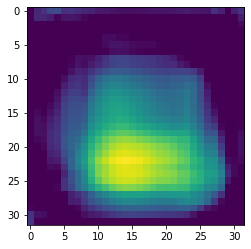

In [ ]:
plt.imshow(pred[0,-1, 10,:,:].cpu().detach().numpy())

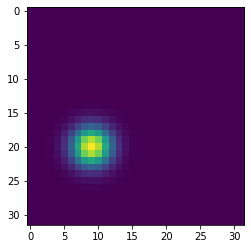

In [ ]:
plt.imshow(hmaps[10,:,:])

In [ ]:
dir = os.path.join(dir_path, "cpm.pth")
torch.save(model.state_dict(), dir)

In [134]:
model = CPM(17).to(device)
dir = os.path.join(dir_path, "cpm_baseline.pth")
model.load_state_dict(torch.load(dir))
model.eval()

CPM(
  (cpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (x_conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (x_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (x_conv2): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (x_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (x_conv3): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (x_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (x_conv4): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s1_conv1): Conv2d(32, 512, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (s1_conv2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (s1_conv3): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (st_conv1): Conv2d(51, 128, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (st_conv2): Conv2d(128, 128, kernel_size=(11, 11), strid

# Proposed CPM

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 

class CPM(nn.Module): # CPM model inherits nn.Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self, num_joints):
    super(CPM, self).__init__()
    self.num_joints = num_joints

    self.cpool = nn.AvgPool2d(8)                               # avg pool operation with kernel size 8 for center_image

    # To extract features (x) for every stage
    self.x_conv1 = nn.Conv2d(3, 128, 9, padding=4)             # (input channels, output channels, kernel size, padding) // output channels = number of kernels used on image, might be good to play around with values
    self.x_pool1 = nn.MaxPool2d(2)                             # max pool operation with kernel size 2
    self.x_conv2 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool2 = nn.MaxPool2d(2)                 
    self.x_conv3 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool3 = nn.MaxPool2d(2)
    self.x_conv4 = nn.Conv2d(128, 32, 5, padding=2)  

    # Stage 1 convolutions:
    self.s1_conv1 = nn.Conv2d(32, 512, 9, padding=4)
    self.s1_conv2 = nn.Conv2d(512, 512, 1)
    self.s1_conv3 = nn.Conv2d(512, num_joints+1, 1)

    # Stage >= 2 (t) convolutions:
    self.st_conv1 = nn.Conv2d(34 + num_joints, 128, 11, padding=5)  # input channels = output channels from image features (x) + output channels from previous stage + 1 channel for loss
    self.st_conv2 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv3 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv4 = nn.Conv2d(128, 128, 1)
    self.st_conv5 = nn.Conv2d(128, num_joints + 1, 1)

  def extract_features(self, im):                                   # input im shape = (N, 3, H, W) // output shape = (N, 32, H/8, W/8)    N = batch size
    x = self.x_pool1(F.relu(self.x_conv1(im)))
    x = self.x_pool2(F.relu(self.x_conv2(x)))
    x = self.x_pool3(F.relu(self.x_conv3(x)))
    return F.relu(self.x_conv4(x))
  
  def stage_1(self, x):                                             # input x shape = (N, 32, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.s1_conv1(x))
    x = F.relu(self.s1_conv2(x))
    return F.relu(self.s1_conv3(x))

  def stage_t(self, x):                                             # input x shape = (N, 34 + num_joints, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.st_conv1(x))
    x = F.relu(self.st_conv2(x))
    x = F.relu(self.st_conv3(x))
    x = F.relu(self.st_conv4(x))
    return F.relu(self.st_conv5(x))
  
  def forward(self, im, center_image): # for 6 stages
    cpool = self.cpool(center_image)

    s1_maps = self.stage_1(self.extract_features(im))
    x = self.extract_features(im)
    s2_maps = self.stage_t(torch.cat([x, s1_maps, cpool], dim=1))
    s2_maps = s2_maps * 0.6
    s3_maps = self.stage_t(torch.cat([x, s2_maps, cpool], dim=1))
    s3_maps = s3_maps * 0.4
    s4_maps = self.stage_t(torch.cat([x, s3_maps, cpool], dim=1))
    s4_maps = s4_maps * 0.4
    s5_maps = self.stage_t(torch.cat([x, s4_maps, cpool], dim=1))
    s5_maps = s5_maps * 0.6
    s6_maps = self.stage_t(torch.cat([x, s5_maps, cpool], dim=1))

    return torch.stack([s1_maps, s2_maps, s3_maps, s4_maps, s5_maps, s6_maps], dim=1)

# U-Net standard implementation (Tom)

In [ ]:

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Input #as INP

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(input_size):
    inputs = Input(shape=input_size, name='primates')
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(18, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    loss_function = tf.keras.losses.MeanSquaredError(reduction='auto',name='mean_squared_error')

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = loss_function, metrics = ['accuracy'])
    
    #model.summary()

    return model

def get_batch_data_tb(data, batch, size):
    batch_data_train_images = []
    batch_data_heat_maps = []
    batch_data_center_heat_map = []

    heat_map_size = (32, 32)
    center_map_size = (256, 256)

    for value in range(len(batch)):
        #print(batch[value])
        if (value%10 ==0):
            print("Processing image #: ",value)
        img = get_image(data, batch[value])
        cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
        #Create ground truth heatmap and center heat map
        heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
        train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
        batch_data_train_images.append(train_image)
        batch_data_heat_maps.append(heat_maps)
        batch_data_center_heat_map.append(center_heat_map)

    batch_data_train_images = np.asarray(batch_data_train_images)
    batch_data_heat_maps = np.asarray(batch_data_heat_maps)
    batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

    return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

Proposed W-Net

In [ ]:

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Input #as INP

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def wnet(input_size):
    inputs = Input(shape=input_size, name='primates')
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(18, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    loss_function = tf.keras.losses.MeanSquaredError(reduction='auto',name='mean_squared_error')

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = loss_function, metrics = ['accuracy'])
    
    #model.summary()

    return model

def get_batch_data_tb(data, batch, size):
    batch_data_train_images = []
    batch_data_heat_maps = []
    batch_data_center_heat_map = []

    heat_map_size = (32, 32)
    center_map_size = (256, 256)

    for value in range(len(batch)):
        #print(batch[value])
        if (value%10 ==0):
            print("Processing image #: ",value)
        img = get_image(data, batch[value])
        cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
        #Create ground truth heatmap and center heat map
        heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
        train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
        batch_data_train_images.append(train_image)
        batch_data_heat_maps.append(heat_maps)
        batch_data_center_heat_map.append(center_heat_map)

    batch_data_train_images = np.asarray(batch_data_train_images)
    batch_data_heat_maps = np.asarray(batch_data_heat_maps)
    batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

    return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

In [ ]:
#https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, trainstate,
                 batch_size,
                 input_size=(256, 256, 3),
                 shuffle=True):
        #self.reset()
        
        #self.df = df.copy()
        #self.X_col = X_col
        #self.y_col = y_col
        self.trainstate = trainstate
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        if (self.trainstate == True):
            Train = True
            self.data_train = Load_Data()
            self.batches_x = create_batches(self.data_train, batch_size)
            self.n = len(self.data_train)
        if (self.trainstate == False):
            Train = False
            self.data_train = Load_Data()
            self.batches_x = create_batches(self.data_train, batch_size)
            self.n = len(self.data_train)
        #self.n_name = df[y_col['name']].nunique()
        #self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            print("Not shuffling")
            #self.data_train = self.data_train.sample(frac=1).reset_index(drop=True)
    
    # def __get_input(self, path, bbox, target_size):
    
    #     xmin, ymin, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']

    #     image = tf.keras.preprocessing.image.load_img(path)
    #     image_arr = tf.keras.preprocessing.image.img_to_array(image)

    #     image_arr = image_arr[ymin:ymin+h, xmin:xmin+w]
    #     image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

    #     return image_arr/255.
    
    # def __get_output(self, label, num_classes):
    #     return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    # def __get_data(self, batches, trainstate):
    #     # Generates data containing batch_size samples
    #     if (self.trainstate == True):
    #         Train = True
    #         data_train = Load_Data()
    #         batches_x = create_batches(data_train, batch_size)
    #         return batches_x
    #     if (self.trainstate == False):
    #         Train = False
    #         data_train = Load_Data()
    #         batches_x = create_batches(data_train, batch_size)
    #         return batches_x

    
    def __getitem__(self, index):
        
        #batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        # Load training data batch
        print("Loading batch ",index)
        x_train, y_train, x_train_center = get_batch_data_tb(self.data_train, self.batches_x[index], crop_size)
        x_train = np.rollaxis(x_train,1,4)
        y_train = np.rollaxis(y_train,1,4)
          # Need to upsize heatmaps to same dimensions as input
        y_train = np.asarray([cv2.resize(y, (256,256)) for y in y_train])

        # # Load validation data
        # if (self.trainstate == False):
        #     print("Loading validation data")
        #     Train = False
        #     x_train, y_train, x_train_center = get_batch_data_tb(data_train, batches_x[i], crop_size)
        #     x_train = np.rollaxis(x_train,1,4)
        #     y_train = np.rollaxis(y_train,1,4)
        #       # Need to upsize heatmaps to same dimensions as input
        #     y_train = np.asarray([cv2.resize(y, (256,256)) for y in y_train])

        return x_train, y_train


        # X, y = self.__get_data(batches)        
        # return X, y
    
    def __len__(self):
        return self.n // self.batch_size

    # def __reset__(self):
    #     #set to intial values


In [ ]:
print("Training")
#batch_size = 2
model_2 = unet(input_size = (256,256,3))

#training_generator.reset()
training_generator = CustomDataGen(True, 32)
validation_generator = CustomDataGen(False, 32)

train_history = model_2.fit_generator(
    generator = training_generator,
    validation_data = validation_generator,
    #x_train,
    #y_train,
    #batch_size=batch_size,
    epochs=2
    #validation_data=(x_val, y_val),
)

In [ ]:
#x_val[0-5,:,:,:].shape
Train = False
data_val = Load_Data()
batch_test = np.array([10,20,30,40,50,60,70,80,90,100])
x_val, y_val, x_val_center = get_batch_data_tb(data_val, batch_test, crop_size)
x_val = np.rollaxis(x_val,1,4)
y_val = np.rollaxis(y_val,1,4)
y_val = np.asarray([cv2.resize(y, (256,256)) for y in y_val])
preds = model_2.predict(x_val)

Processing image #:  0


# Metrics

In [135]:
def mpjpe(ground_truth, preds):
  number_joints = 17
  number_images = len(ground_truth)

  error_mpjpe = np.zeros(number_joints)

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      error_mpjpe[landmark] = error_mpjpe[landmark] + (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width
    print(error_mpjpe)
  error_mpjpe = error_mpjpe/number_images
  print(error_mpjpe)
  return error_mpjpe

def pck(ground_truth, preds):
  number_joints = 17
  error = 0
  number_images = len(ground_truth)
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)
      if(pck_value < thresh):
        pck_value = 1
      else:
        pck_value = 0
      error = error + pck_value
      #print(error)
  error = error/(number_joints * number_images)
  return error

def ap(ground_truth, preds):
  error = 0
  number_images = len(ground_truth)
  number_joints = 17
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      oks_value = OKS(ground_truth[img]['landmarks'][landmark], preds[img]['landmarks'][landmark], width) 
      #print(oks_value)
      if(oks_value >= thresh):
        oks_value = 1
      else:
        oks_value = 0
      error = error + oks_value
      #print(error)
  error = error/(number_images * number_joints)

  return error

def OKS(ground_truth, pred, width, k = 0.5):
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


def json_to_dictionary(filepath):
  with open(filepath) as f:
    json_dictionary = json.load(f)
    dictionary = {}
    for data in json_dictionary['data']:
      landmarks = data['landmarks']
      position_pairs = []
      for value in range(len(landmarks)//2):
        position_pairs.append([landmarks[value], landmarks[value + 1]])
      dictionary[data['file']] = {'bbox': data['bbox'], 'landmarks': np.array(position_pairs)}
  
  return dictionary



In [136]:
#Baseline CPM

if __name__ == '__main__':
  path = dir_path #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'val_prediction.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  #mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  mpjpe_error = mpjpe(ground_truth, preds)
  pck_accuracy = pck(ground_truth, preds)
  ap_accuracy = ap(ground_truth, preds)
  print("Baseline CPM - mpjpe: {}, pck: {}, ap: {}".format(mpjpe_error, pck_accuracy, ap_accuracy))

Streaming output truncated to the last 5000 lines.
 15476.80446188 15430.91269849 13852.62856447  5837.54462164
  1189.20376105  1297.81618132  1426.92009077  1582.28913536
  1656.99864543  1973.78912702  2244.72740435  1876.98982361
  1358.35743291]
[  859.851924     863.7844124    850.77628104 12326.2066538
 15477.86590195 15431.98240932 13853.6316352   5838.07369983
  1189.27708303  1297.88576849  1427.0157292   1582.36986182
  1657.03762529  1973.8058537   2244.74619145  1877.03722469
  1358.40979569]
[  859.87767794   863.80837027   850.79710587 12326.95686635
 15478.70442744 15432.79865071 13854.40960024  5838.35694812
  1189.31780358  1297.94520891  1427.0688223   1582.38909455
  1657.06362568  1973.86175539  2244.80563187  1877.07110623
  1358.43062052]
[  859.92757241   863.84894299   850.83383869 12327.61192696
 15479.4756111  15433.52411228 13855.08572863  5838.66916628
  1189.3359854   1297.95559852  1427.07953167  1582.39169195
  1657.0766127   1973.9052958   2244.8472714 

In [35]:
#Baseline UNet

if __name__ == '__main__':

  

  path = dir_path #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'preds_UNet.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  ap = ap(ground_truth, preds)

  print("Baseline UNet - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))

FileNotFoundError: ignored

In [ ]:
#Proposed CPM

if __name__ == '__main__':
  path = dir_path #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'preds_CPM_Proposed.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  ap = ap(ground_truth, preds)

  print("Proposed CPM - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))

FileNotFoundError: ignored

In [ ]:
#Proposed UNet

if __name__ == '__main__':
  path = " " #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'preds_UNet.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  ap = ap(ground_truth, preds)

  print("Proposed UNet - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))